# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
floyd run --gpu --env tensorflow --mode jupyter --data /R5KrjnANiKVhLWAkpXhNBe

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


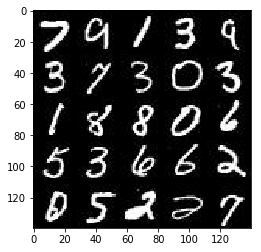

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

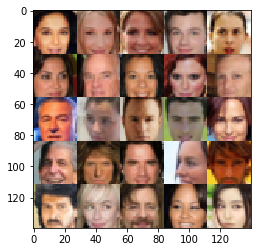

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1,3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, x4 * alpha)
#         print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         print(logits.get_shape())
        
        out = tf.tanh(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return images_grid

In [11]:
import scipy.misc
pic_dir = 'images/'
!mkdir images

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        img = show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
        scipy.misc.imsave(pic_dir + 'img_{}.jpg'.format(step), img)
        
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Step: {}...".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    img = show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
                    scipy.misc.imsave(pic_dir + 'img_{}.jpg'.format(step/show_every), img)
                    
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
!mkdir 'checkpoints'

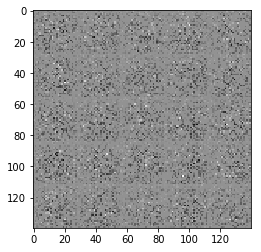

Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.6258
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.4958
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 3.8112


KeyboardInterrupt: 

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

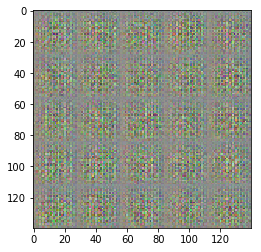

Step: 10... Epoch 1/1... Discriminator Loss: 2.0091... Generator Loss: 1.4065
Step: 20... Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 3.9751
Step: 30... Epoch 1/1... Discriminator Loss: 3.5088... Generator Loss: 0.0694
Step: 40... Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 2.0506
Step: 50... Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.0733
Step: 60... Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 3.3495
Step: 70... Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 2.2468
Step: 80... Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.6819
Step: 90... Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 3.5175
Step: 100... Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 6.2705


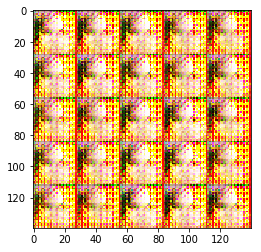

Step: 110... Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.3012
Step: 120... Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.7338
Step: 130... Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.6623
Step: 140... Epoch 1/1... Discriminator Loss: 1.8578... Generator Loss: 0.5975
Step: 150... Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.5818
Step: 160... Epoch 1/1... Discriminator Loss: 2.0256... Generator Loss: 0.5245
Step: 170... Epoch 1/1... Discriminator Loss: 1.9130... Generator Loss: 0.8580
Step: 180... Epoch 1/1... Discriminator Loss: 1.9649... Generator Loss: 0.7242
Step: 190... Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.6131
Step: 200... Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.7318


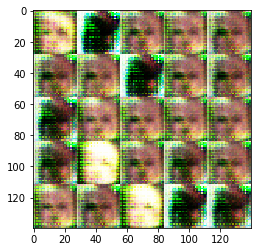

Step: 210... Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.6021
Step: 220... Epoch 1/1... Discriminator Loss: 1.7676... Generator Loss: 1.1036
Step: 230... Epoch 1/1... Discriminator Loss: 2.2652... Generator Loss: 0.4634
Step: 240... Epoch 1/1... Discriminator Loss: 1.6538... Generator Loss: 0.5359
Step: 250... Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.6760
Step: 260... Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4932
Step: 270... Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6580
Step: 280... Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.7171
Step: 290... Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.6885
Step: 300... Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9147


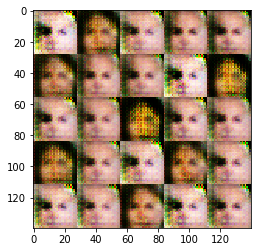

Step: 310... Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6616
Step: 320... Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9317
Step: 330... Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 0.5728
Step: 340... Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.9705
Step: 350... Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9835
Step: 360... Epoch 1/1... Discriminator Loss: 1.6786... Generator Loss: 0.6043
Step: 370... Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.6445
Step: 380... Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.8053
Step: 390... Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.7721
Step: 400... Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.6355


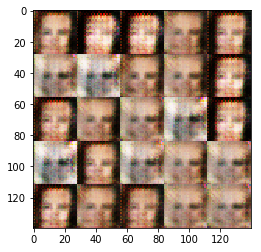

Step: 410... Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.6440
Step: 420... Epoch 1/1... Discriminator Loss: 1.6599... Generator Loss: 0.6717
Step: 430... Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.7705
Step: 440... Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.7481
Step: 450... Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.7012
Step: 460... Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 0.6255
Step: 470... Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.5707
Step: 480... Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8247
Step: 490... Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 0.7252
Step: 500... Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.5770


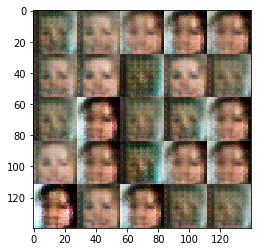

Step: 510... Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9720
Step: 520... Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7641
Step: 530... Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.6271
Step: 540... Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8357
Step: 550... Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8913
Step: 560... Epoch 1/1... Discriminator Loss: 1.8104... Generator Loss: 0.5191
Step: 570... Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8463
Step: 580... Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.7235
Step: 590... Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6963
Step: 600... Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6785


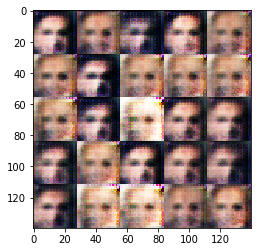

Step: 610... Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.6825
Step: 620... Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.6607
Step: 630... Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8094
Step: 640... Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6772
Step: 650... Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.7294
Step: 660... Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6881
Step: 670... Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7599
Step: 680... Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.7211
Step: 690... Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7273
Step: 700... Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7271


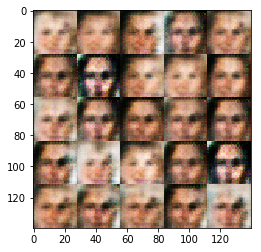

Step: 710... Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7566
Step: 720... Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.7286
Step: 730... Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.7125
Step: 740... Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7283
Step: 750... Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7240
Step: 760... Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6870
Step: 770... Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7007
Step: 780... Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7683
Step: 790... Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7479
Step: 800... Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6993


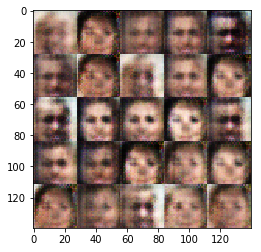

Step: 810... Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7731
Step: 820... Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8161
Step: 830... Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6441
Step: 840... Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6824
Step: 850... Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8415
Step: 860... Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7451
Step: 870... Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.7564
Step: 880... Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.6740
Step: 890... Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7411
Step: 900... Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7514


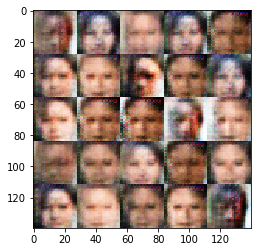

Step: 910... Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6931
Step: 920... Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7367
Step: 930... Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.6815
Step: 940... Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7272
Step: 950... Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.7400
Step: 960... Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7572
Step: 970... Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7743
Step: 980... Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7126
Step: 990... Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8324
Step: 1000... Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7561


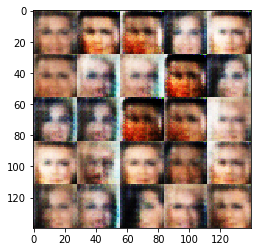

Step: 1010... Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7702
Step: 1020... Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.7309
Step: 1030... Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7667
Step: 1040... Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.8412
Step: 1050... Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.8370
Step: 1060... Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7632
Step: 1070... Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.7481
Step: 1080... Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7739
Step: 1090... Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.7414
Step: 1100... Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.7782


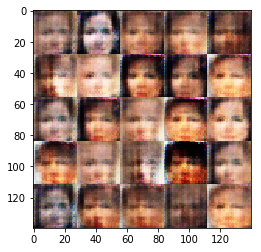

Step: 1110... Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.7586
Step: 1120... Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7508
Step: 1130... Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7562
Step: 1140... Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7596
Step: 1150... Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7539
Step: 1160... Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7505
Step: 1170... Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7029
Step: 1180... Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6935
Step: 1190... Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7867
Step: 1200... Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7917


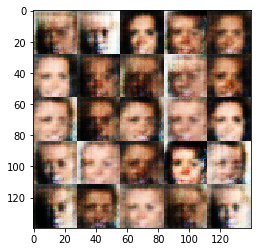

Step: 1210... Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7235
Step: 1220... Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7547
Step: 1230... Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7388
Step: 1240... Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7618
Step: 1250... Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7750
Step: 1260... Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7471
Step: 1270... Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7402
Step: 1280... Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7532
Step: 1290... Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7200
Step: 1300... Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6820


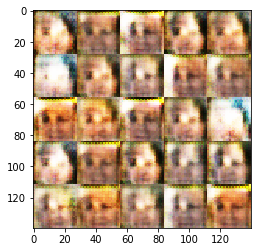

KeyboardInterrupt: 

In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.